In [2]:
# Cell 1: Import required libraries and generate synthetic data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic data
np.random.seed(42)
n_students = 1000
n_questions = 50

data = {
    'student_id': np.repeat(range(1, n_students + 1), n_questions),
    'question_id': np.tile(range(1, n_questions + 1), n_students),
    'question_category': np.random.choice(['Python Basics', 'Data Structures', 'Functions', 'OOP', 'File Handling'], n_students * n_questions),
    'difficulty': np.random.choice(['Easy', 'Medium', 'Hard'], n_students * n_questions),
    'is_correct': np.random.choice([0, 1], n_students * n_questions, p=[0.3, 0.7]),  # 70% correct answers
    'time_taken': np.random.normal(loc=60, scale=20, size=n_students * n_questions).astype(int),
    'attempts': np.random.randint(1, 4, n_students * n_questions)
}

df = pd.DataFrame(data)

# Add some realistic patterns
df.loc[df['difficulty'] == 'Hard', 'is_correct'] = np.random.choice([0, 1], sum(df['difficulty'] == 'Hard'), p=[0.5, 0.5])
df.loc[df['difficulty'] == 'Easy', 'is_correct'] = np.random.choice([0, 1], sum(df['difficulty'] == 'Easy'), p=[0.2, 0.8])
df.loc[df['attempts'] > 2, 'is_correct'] = np.random.choice([0, 1], sum(df['attempts'] > 2), p=[0.6, 0.4])

# Save to CSV
file_path = 'python_quiz_data.csv'
df.to_csv(file_path, index=False)
print(f"Data saved to {file_path}")

Data saved to python_quiz_data.csv


In [4]:
# Cell 2: Load and preprocess data
# Load the data
df = pd.read_csv('python_quiz_data.csv')
print("Data loaded successfully.")
print("\nFirst few rows of the loaded data:")
display(df.head())

# Preprocess the data
def preprocess_data(df):
    df_encoded = pd.get_dummies(df, columns=['question_category', 'difficulty'])
    df_encoded['time_taken_normalized'] = (df_encoded['time_taken'] - df_encoded['time_taken'].mean()) / df_encoded['time_taken'].std()
    return df_encoded

df_processed = preprocess_data(df)
print("\nFirst few rows of the preprocessed data:")
display(df_processed.head())

# Prepare features and target
X = df_processed.drop(['is_correct', 'student_id', 'question_id'], axis=1)
y = df_processed['is_correct']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data loaded successfully.

First few rows of the loaded data:


,student_id,question_id,question_category,difficulty,is_correct,time_taken,attempts
0,1,1,OOP,Hard,1,56,2
1,1,2,File Handling,Hard,0,54,2
2,1,3,Functions,Hard,1,102,3
3,1,4,File Handling,Hard,0,57,1
4,1,5,File Handling,Easy,1,94,2



First few rows of the preprocessed data:


,student_id,question_id,is_correct,time_taken,attempts,question_category_Data Structures,question_category_File Handling,question_category_Functions,question_category_OOP,question_category_Python Basics,difficulty_Easy,difficulty_Hard,difficulty_Medium,time_taken_normalized
0,1,1,1,56,2,False,False,False,True,False,False,True,False,-0.174962
1,1,2,0,54,2,False,True,False,False,False,False,True,False,-0.275102
2,1,3,1,102,3,False,False,True,False,False,False,True,False,2.128263
3,1,4,0,57,1,False,True,False,False,False,False,True,False,-0.124892
4,1,5,1,94,2,False,True,False,False,False,True,False,False,1.727702


In [6]:
# Cell 3: Train and evaluate models
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Train and evaluate XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"\nXGBoost Accuracy: {xgb_accuracy:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

# Use the better performing model
best_model = rf_model if rf_accuracy > xgb_accuracy else xgb_model

Random Forest Accuracy: 0.6188

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      4210
           1       0.66      0.70      0.68      5790

    accuracy                           0.62     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.62      0.62      0.62     10000



C:\Users\saral\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [23:14:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.6399

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      4210
           1       0.69      0.68      0.69      5790

    accuracy                           0.64     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.64      0.64      0.64     10000




Feature Importance:


,feature,importance
8,difficulty_Hard,0.481682
1,attempts,0.295707
7,difficulty_Easy,0.074639
5,question_category_OOP,0.025728
4,question_category_Functions,0.025301
2,question_category_Data Structures,0.024558
6,question_category_Python Basics,0.020466
3,question_category_File Handling,0.018541
0,time_taken,0.017617
9,difficulty_Medium,0.015761


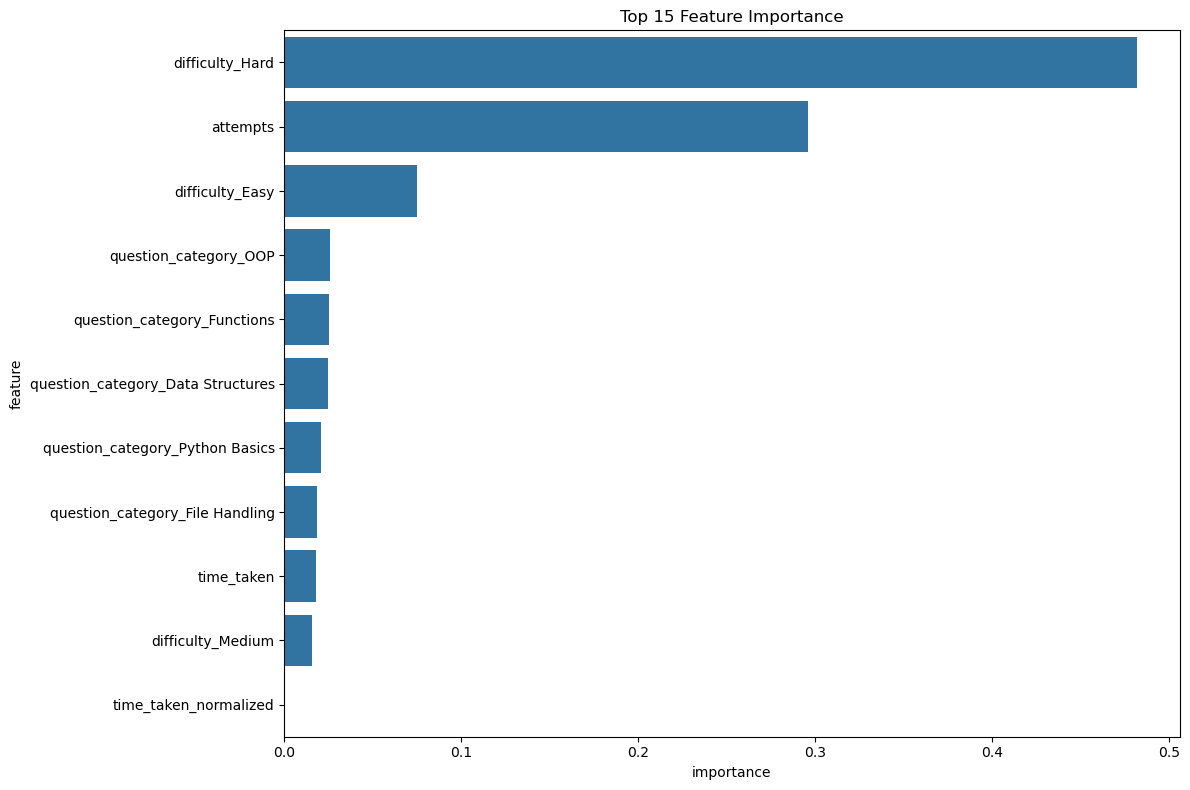

In [8]:
# Cell 4: Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
display(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

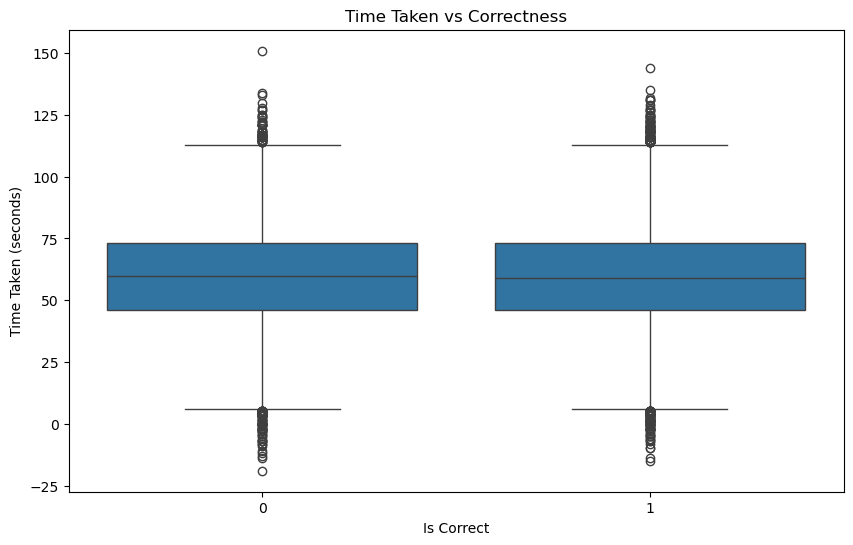

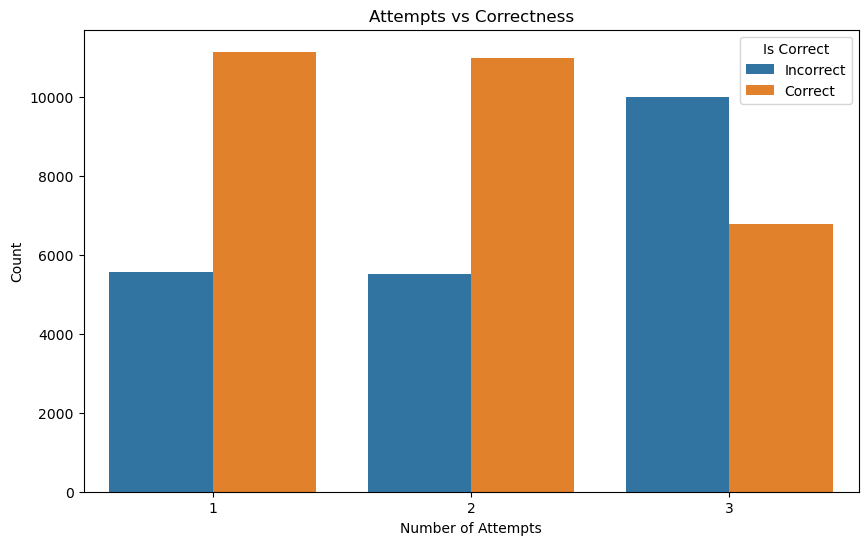

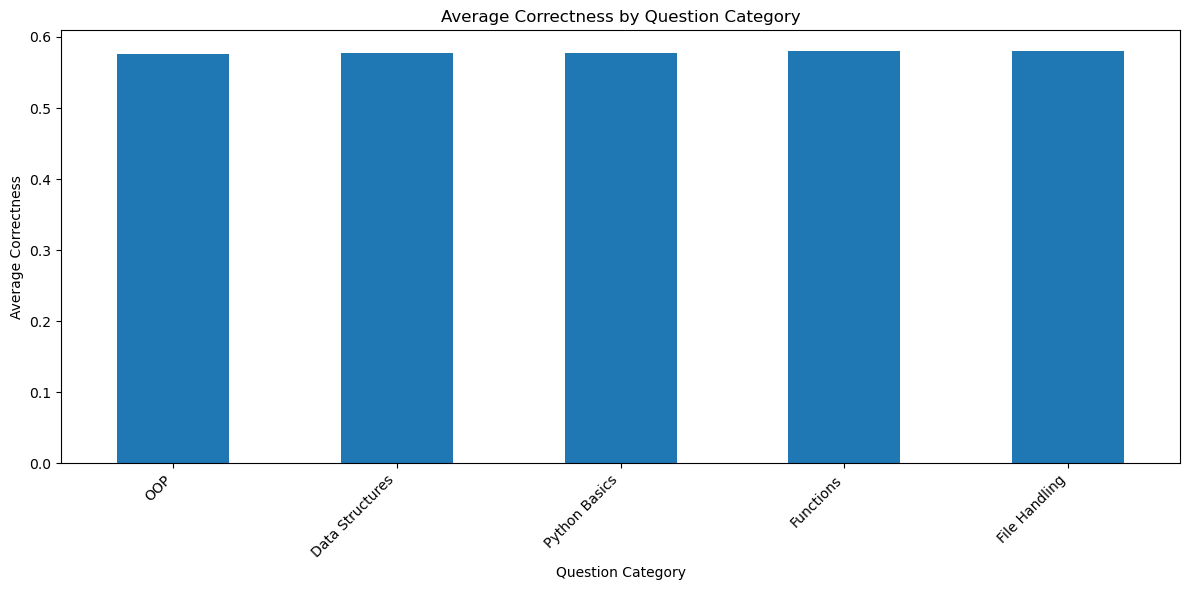

In [10]:
# Cell 5: Data Visualization
# Time taken vs Correctness
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_correct', y='time_taken', data=df)
plt.title('Time Taken vs Correctness')
plt.xlabel('Is Correct')
plt.ylabel('Time Taken (seconds)')
plt.show()

# Attempts vs Correctness
plt.figure(figsize=(10, 6))
sns.countplot(x='attempts', hue='is_correct', data=df)
plt.title('Attempts vs Correctness')
plt.xlabel('Number of Attempts')
plt.ylabel('Count')
plt.legend(title='Is Correct', labels=['Incorrect', 'Correct'])
plt.show()

# Correctness by Question Category
category_correctness = df.groupby('question_category')['is_correct'].mean().sort_values()
plt.figure(figsize=(12, 6))
category_correctness.plot(kind='bar')
plt.title('Average Correctness by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Average Correctness')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Cell 6: Insights and Recommendations
print("Insights and Recommendations:")
print("1. Most important features for predicting correctness:")
for feature, importance in feature_importance.head(5).values:
    print(f"   - {feature}: {importance:.4f}")

print("\n2. Weakest areas (Categories with lowest correctness):")
for category, correctness in category_correctness.head(3).items():
    print(f"   - {category}: {correctness:.2f}")

print("\n3. Time management:")
avg_time_correct = df[df['is_correct'] == 1]['time_taken'].mean()
avg_time_incorrect = df[df['is_correct'] == 0]['time_taken'].mean()
print(f"   - Average time for correct answers: {avg_time_correct:.2f} seconds")
print(f"   - Average time for incorrect answers: {avg_time_incorrect:.2f} seconds")

print("\n4. Impact of multiple attempts:")
for attempts in range(1, 4):
    success_rate = df[df['attempts'] == attempts]['is_correct'].mean()
    print(f"   - Success rate with {attempts} attempt(s): {success_rate:.2f}")

print("\nRecommendations:")
print("1. Focus on improving understanding in the weakest areas identified.")
print("2. Provide additional resources and practice for difficult question categories.")
print("3. Encourage time management: students spending too little time might be guessing, while those spending too much might be struggling.")
print("4. Consider allowing multiple attempts for questions, as it seems to improve success rates.")
print("5. Tailor the difficulty of questions based on student performance to provide appropriate challenges.")

Insights and Recommendations:
1. Most important features for predicting correctness:
   - difficulty_Hard: 0.4817
   - attempts: 0.2957
   - difficulty_Easy: 0.0746
   - question_category_OOP: 0.0257
   - question_category_Functions: 0.0253

2. Weakest areas (Categories with lowest correctness):
   - OOP: 0.58
   - Data Structures: 0.58
   - Python Basics: 0.58

3. Time management:
   - Average time for correct answers: 59.56 seconds
   - Average time for incorrect answers: 59.41 seconds

4. Impact of multiple attempts:
   - Success rate with 1 attempt(s): 0.67
   - Success rate with 2 attempt(s): 0.67
   - Success rate with 3 attempt(s): 0.40

Recommendations:
1. Focus on improving understanding in the weakest areas identified.
2. Provide additional resources and practice for difficult question categories.
3. Encourage time management: students spending too little time might be guessing, while those spending too much might be struggling.
4. Consider allowing multiple attempts for ques